In [ ]:
# Local Outlier Factor

In [ ]:
import pandas as pd
import time
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import  pairwise 
import sklearn.model_selection

In [3]:
start = time.time()
df = pd.read_csv('1mill_sample_anomaly.csv')
end = time.time()
print(end - start)

1.8854968547821045


In [4]:
#df2 = df.sample(n=1000000)
dfNum = df[['Duration', 'SrcPackets', 'DstPackets', 'SrcBytes', 'DstBytes']]

In [9]:
# small n, high variance. N=length, then find most probable class
# auto chooses best algorithm based on data passed into fit
start = time.time()
lof = LocalOutlierFactor(n_neighbors = 20, algorithm= 'auto', contamination= 0.05)
labels = lof.fit_predict(dfNum)
end = time.time()
print(end - start)

1062.5657420158386


In [10]:
# Intra cluster distance 
start = time.time()
dfNum['Outlier'] = labels
benign = dfNum[dfNum['Outlier'] == 1]
anomalies = dfNum[dfNum['Outlier'] == -1]
benign_centroid = benign.mean().values
full_centroid = dfNum.mean().values

full_spread = 0
for index, row in dfNum.iterrows():
    d = np.sum(np.square(full_centroid - row.values))
    full_spread = full_spread + d
    
benign_spread = 0
for index, row in benign.iterrows():
    d = np.sum(np.square(benign_centroid - row.values))
    benign_spread = benign_spread + d
    
ratio = (full_spread / dfNum.shape[0]) / (benign_spread / benign.shape[0])
print(ratio)
end = time.time()
print(end - start)

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


3.9171913167474237
149.37739300727844


In [11]:
# Adding column to dataframe and resaving ensembling csv
df['LOF_0.01_Labels'] = labels
df.to_csv('1mill_anomaly_ensemble_df.csv')

In [38]:
# Removing 'Port' from the port names and grouping ports into 3 categories
df['DstPort'] = df['DstPort'].str.replace('Port', '')
df['DstPort'] = df['DstPort'].astype(int)
df['DstPortCategory'] = np.where(df['DstPort']<=1023, 'System Ports', 'User Ports')
df['DstPortCategory'][df['DstPort']>=49152] = 'Dynamic and/or Private Ports'

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [41]:
# Chi-Squared Test to Test Whether Anomalous and Benign Five-Tuples have significantly 
# differnt port dist
#df['Outlier'] = labels
cont_tab = pd.crosstab(index=df['Outlier'], columns=df['DstPortCategory'])
print(cont_tab)
from scipy import stats
stats.chi2_contingency(cont_tab)

DstPortCategory  Dynamic and/or Private Ports  System Ports  User Ports
Outlier                                                                
-1                                       1647          5772        2624
 1                                     197321        512702      279934


(140.54577938210352,
 3.0260199002442524e-31,
 2,
 array([[  1998.235624,   5207.034382,   2837.729994],
        [196969.764376, 513266.965618, 279720.270006]]))

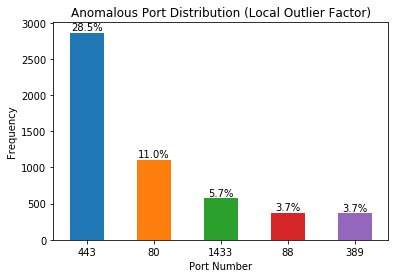

In [33]:
# Creating a plot of the ports for anomalous five tuples
anomalies2 = df[df['Outlier']==-1]
freq_series = pd.Series(anomalies2['DstPort'].value_counts().head(5).values)
x_labels = pd.Series(anomalies2['DstPort'].value_counts().head(5).index)
ax = freq_series.plot(kind='bar')
ax.set_title('Anomalous Port Distribution (Local Outlier Factor)')
ax.set_xlabel('Port Number')
ax.set_ylabel('Frequency')
ax.set_xticklabels(x_labels)
plt.xticks(rotation=360)
rects = ax.patches

# Make some labels.
#labels = ["label%d" % i for i in range(len(rects))]
percs = list(anomalies2['DstPort'].value_counts().head(6)*100/len(anomalies2))
percs = [round(perc, 1) for perc in percs]
labels = [str(perc)+'%' for perc in percs]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.savefig('LOF_anomalous_portDist_0.01contam.png')

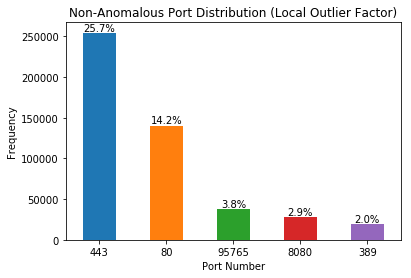

In [37]:
# Creating a plot of the ports for anomalous five tuples
anomalies2 = df[df['Outlier']==1]
freq_series = pd.Series(anomalies2['DstPort'].value_counts().head(5).values)
x_labels = pd.Series(anomalies2['DstPort'].value_counts().head(5).index)
ax = freq_series.plot(kind='bar')
ax.set_title('Non-Anomalous Port Distribution (Local Outlier Factor)')
ax.set_xlabel('Port Number')
ax.set_ylabel('Frequency')
ax.set_xticklabels(x_labels)
plt.xticks(rotation=360)
rects = ax.patches

# Make some labels.
#labels = ["label%d" % i for i in range(len(rects))]
percs = list(anomalies2['DstPort'].value_counts().head(6)*100/len(anomalies2))
percs = [round(perc, 1) for perc in percs]
labels = [str(perc)+'%' for perc in percs]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.savefig('LOF_nonanomalous_portDist_0.01contam.png')

In [15]:
# Chi-Squared Test to Test Whether Anomalous and Benign Five-Tuples have significantly 
# differnt protocol dist
df['Outlier'] = labels
cont_tab2 = pd.crosstab(index=df['Outlier'], columns=df['Protocol'])
print(cont_tab2)
from scipy import stats
stats.chi2_contingency(cont_tab2)

Protocol      6      17
Outlier                
-1          9247    796
 1        947331  42626


(312.80753444575055,
 5.341103011335607e-70,
 1,
 array([[9.60691285e+03, 4.36087146e+02],
        [9.46971087e+05, 4.29859129e+04]]))

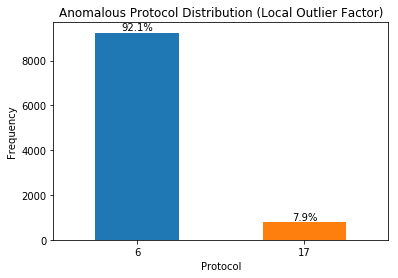

In [32]:
# Creating a plot of the protocols for anomalous five tuples
anomalies2 = df[df['Outlier']==-1]
freq_series = pd.Series(anomalies2['Protocol'].value_counts().values)
x_labels = pd.Series(anomalies2['Protocol'].value_counts().index)
ax = freq_series.plot(kind='bar')
ax.set_title('Anomalous Protocol Distribution (Local Outlier Factor)')
ax.set_xlabel('Protocol')
ax.set_ylabel('Frequency')
ax.set_xticklabels(x_labels)
plt.xticks(rotation=360)
rects = ax.patches

# Make some labels.
#labels = ["label%d" % i for i in range(len(rects))]
percs = list(anomalies2['Protocol'].value_counts()*100/len(anomalies2))
percs = [round(perc, 1) for perc in percs]
labels = [str(perc)+'%' for perc in percs]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.savefig('LOF_anomalous_protocolDist_0.01contam.png')

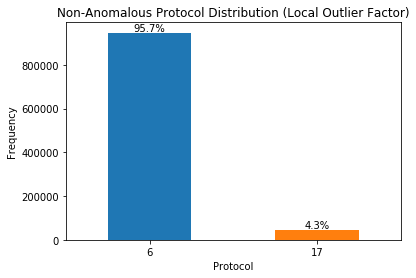

In [31]:
# Creating a plot of the protocols for non-anomalous five tuples
benign2 = df[df['Outlier']==1]
freq_series = pd.Series(benign2['Protocol'].value_counts().values)
x_labels = pd.Series(benign2['Protocol'].value_counts().index)
ax = freq_series.plot(kind='bar')
ax.set_title('Non-Anomalous Protocol Distribution (Local Outlier Factor)')
ax.set_xlabel('Protocol')
ax.set_ylabel('Frequency')
ax.set_xticklabels(x_labels)
plt.xticks(rotation=360)
rects = ax.patches

# Make some labels.
#labels = ["label%d" % i for i in range(len(rects))]
percs = list(benign2['Protocol'].value_counts()*100/len(benign2))
percs = [round(perc, 1) for perc in percs]
labels = [str(perc)+'%' for perc in percs]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.savefig('LOF_benign_protocolDist_0.01contam.png')

In [30]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [18]:
# Plotting PCA to Visualize Anomalies
# Scaling for PCA
start = time.time()
pre = preprocessing.scale(dfNum[["Duration", "SrcPackets", "DstPackets", "SrcBytes", "DstBytes"]])
pre = pd.DataFrame.from_records(pre, columns = ["Duration", "SrcPackets", "DstPackets", "SrcBytes", "DstBytes"])
print(pre.head())
end = time.time()
print(end - start)

   Duration  SrcPackets  DstPackets  SrcBytes  DstBytes
0 -0.059926   -0.008064   -0.006648 -0.012190 -0.005534
1 -0.060076   -0.007932   -0.006575 -0.012149 -0.005514
2 -0.060076   -0.007203   -0.005955 -0.011607 -0.004824
3 -0.059926   -0.008197   -0.006685 -0.012234 -0.005536
4 -0.060076   -0.007601   -0.006466 -0.011705 -0.005417
3.5990962982177734


In [19]:
dfNum['Outlier'] = labels

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


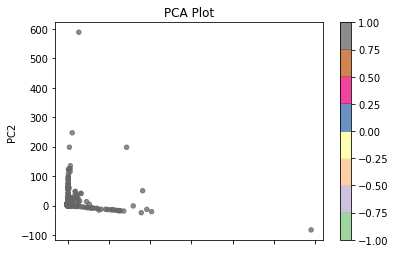

131.7515320777893


In [20]:
# PCA plot of protocol and numerical values-- color coded by Protocol
start = time.time()
pcaDF = pre[["Duration", "SrcPackets", "DstPackets", "SrcBytes", "DstBytes"]]
pca = PCA(n_components=2).fit_transform(pcaDF)
pcdf = pd.DataFrame(data = pca, columns = ['PC1', 'PC2'])
pcdf.plot(x="PC1", y="PC2", kind='scatter', title='PCA Plot', 
          c=dfNum['Outlier'] , legend=True, colormap = 'Accent', alpha = 0.05)
plt.savefig('1mill_PCA_LOF.pdf')
plt.show()
end = time.time()
print(end - start)